In [56]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import pytorch_lightning as pl
from torch import nn
import math
from itertools import product

import os, sys
sys.path.append(os.path.join(os.getcwd(), '../symlie'))

from run import parse_options, main

from model.learner import PredictionLearner, TransformationLearner
from model.networks.mlp import MLP
from model.networks.linear import  LinearP
from data.dataset import FlatDataset
from data.datamodule import BaseDataModule
from data.transforms import Transform
from misc.viz import plot1d
from misc.utils import Args
from model.setup import find_id_for_P, load_P_pred

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
data_kwargs = {
        'grid_size': (1,7),
        'noise_std' : 0.5,
        'y_low' : 1,
        'y_high' : 3,
    }
transform_kwargs = {
    'eps_mult' : [0., 0., 1., 0.],
    'only_flip' : False,
}

args = {
    'data_kwargs' : data_kwargs,
    'transform_kwargs' : transform_kwargs,
    'seed' : 1,
    'data_dir' : '../data/sine1d',
}

args = Args(**args)
args

Found run_id cpw6d6pz


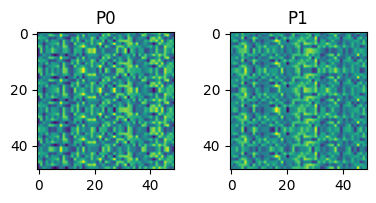

In [173]:
P_sine1d = load_P_pred(find_id_for_P(args))
P_noise  = load_P_pred(run_id = '548ghibn')
Ps = [P_sine1d, P_noise]

fig, axs = plt.subplots(1,2, figsize=(2*len(Ps),2), tight_layout=True)
for i, P in enumerate(Ps):
    axs[i].imshow(P)
    axs[i].set_title(f'P{i}')
plt.show()

In [174]:
net = MLP(
    in_features = 7, 
    out_features = 1,
    bias = False,
    device = 'cpu',
    P_init = 'space_translation',
)

net = LinearP(
    in_features = 7, 
    out_features = 7,
    bias = False,
    device = 'cpu',
    # P_init = P_sine1d,
    P_init = P_noise,
    train_weights = True,
    train_P = False,
)

In [200]:
dataset = FlatDataset(
    mode = 'val', 
    task = 'regression', 
    data_kwargs = data_kwargs,
    transform_kwargs = transform_kwargs,  
    data_dir = '../data/sine1d',
)

N, N_plot = 100, 5
xs, y, _centers = d = dataset[:N]

torch.Size([100, 2, 7])


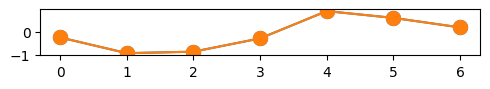

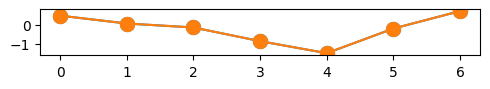

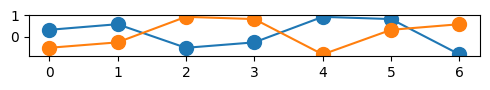

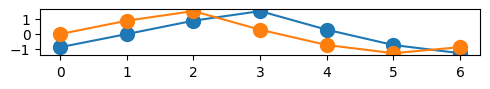

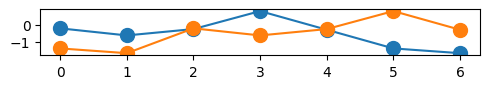

In [201]:
def plot(x, figsize = (5,1)):
    plt.figure(figsize=figsize, tight_layout=True)
    plt.plot(x.T, markersize = 10, marker = 'o')
    plt.show()

transform = Transform(grid_size=data_kwargs['grid_size'], **transform_kwargs)
xprimes, _centers = transform(xs, centers = _centers, epsilons = torch.rand(N, 4), transform_individual_bool=True)

x_ins = torch.stack([xs, xprimes], dim=1)
print(x_ins.shape)

for x_in in x_ins[:N_plot]:
    plot(x_in)

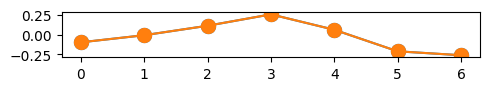

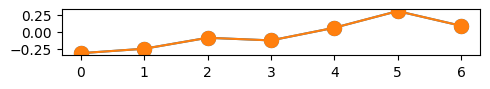

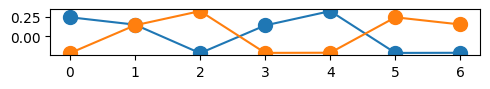

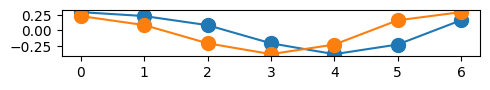

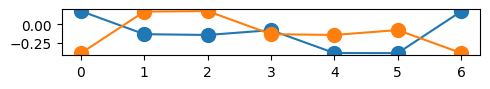

In [205]:
x_outs = net(x_ins).detach()
for x_out in x_outs[:N_plot]:
    plot(x_out)

In [218]:
x_outs_aligned

torch.Size([100, 2, 7])

In [221]:
x_out_aligned

torch.Size([2, 7])

tensor([0.0000e+00, 0.0000e+00, 9.7100e-07, 7.7174e-07, 6.2826e-07, 3.8623e-07,
        1.6582e-06, 0.0000e+00, 3.2937e-06, 7.7423e-07, 8.9665e-07, 0.0000e+00,
        3.2827e-07, 0.0000e+00, 2.6664e-07, 4.3549e-07, 6.4195e-07, 1.3704e-06,
        5.3319e-07, 7.8628e-07, 8.8393e-07, 0.0000e+00, 1.5018e-06, 0.0000e+00,
        3.7773e-07, 0.0000e+00, 4.0310e-07, 6.1877e-07, 2.6870e-07, 7.7383e-07,
        6.5501e-07, 2.0175e-07, 2.4845e-07, 6.7301e-07, 1.1814e-06, 1.0632e-06,
        6.5818e-07, 1.9436e-06, 1.8391e-06, 7.5897e-07, 2.5541e-07, 3.0922e-07,
        4.7791e-07, 4.3980e-07, 3.2925e-07, 0.0000e+00, 1.7644e-06, 2.5457e-07,
        9.9515e-07, 1.7775e-07, 5.3165e-07, 2.1042e-06, 5.8961e-07, 1.1866e-07,
        7.1089e-07, 2.5361e-06, 2.6875e-07, 5.1798e-07, 8.7573e-07, 6.1522e-07,
        5.0100e-07, 8.0492e-07, 1.1007e-06, 7.5807e-07, 5.7402e-07, 5.8539e-07,
        6.9291e-07, 7.7219e-07, 1.1313e-06, 2.3676e-07, 5.0339e-07, 5.7354e-07,
        6.6043e-07, 4.1981e-07, 9.0244e-

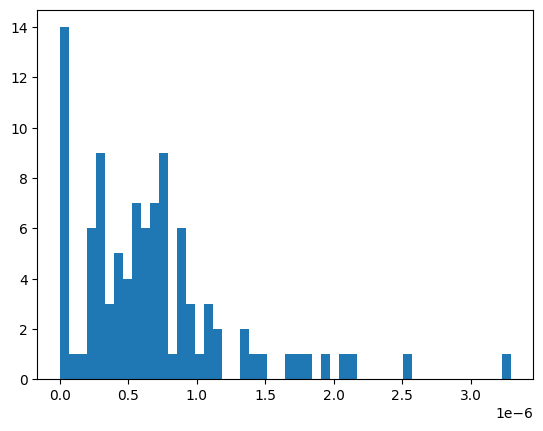

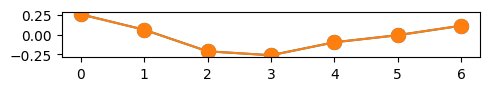

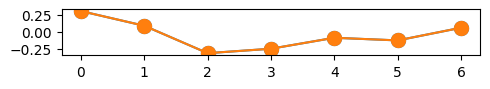

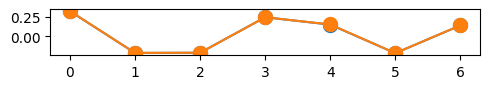

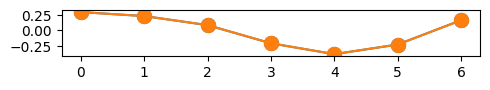

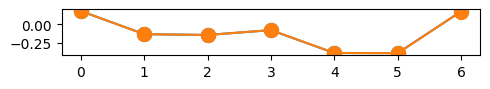

In [231]:
x_outs_flat = x_outs.reshape(N*2, -1)
x_outs_aligned = torch.stack([torch.roll(x_out_i, -argmax.item()) for x_out_i, argmax in zip(x_outs_flat, torch.argmax(x_outs_flat, dim=1))])
x_outs_aligned = x_outs_aligned.reshape(N, 2, -1)


loss_fn = nn.MSELoss()
losses = torch.stack([loss_fn(*x_out_aligned) for x_out_aligned in x_outs_aligned])

plt.figure()
plt.hist(losses.numpy(), bins = 50)
plt.show()

for x_out_aligned in x_outs_aligned[:N_plot]:
    plot(x_out_aligned)